In [1]:
import sys
sys.dont_write_bytecode = True

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas

import h3
import matplotlib.pyplot as plt


# Local imports.
from resale_flat_prices.resale_flat_data.resale_flat_data import ResaleFlatData
from resale_flat_prices.h3_utils.h3_statistics import grid_ring_monthly_median_price
from resale_flat_prices.h3_utils.h3_vis_utils import plot_df


# Data directories.
csv_data_dir = Path("../data/ResaleFlatPrices/")
processed_data_dir = Path("../data/processed_data/")

In [2]:
# Load processed and geocoded data.
csv_file = "resale-flat-prices.csv.zip"

disp_columns = [
    "year_month", "town", "block", "street_name", "flat_type", "storey_range", "floor_area_sqm", "age",
    "resale_price", "price_per_sqm", "price_per_sqft"
]

resale_flat_data = ResaleFlatData(processed_data_dir / csv_file)
resale_flat_data.read_csv()
resale_flat_data.df = resale_flat_data.df.sort_values(["year_month", "town"])

resale_flat_data.df["quarter"] = resale_flat_data.df["month"].apply(lambda x: int(np.ceil(x / 3)))
resale_flat_data.df["year_quarter"] = resale_flat_data.df.apply(lambda DF: str(DF["year"]) + "-" + str(DF["quarter"]), axis = 1)

display(resale_flat_data.df[disp_columns].tail())
print(resale_flat_data.df.shape)

,year_month,town,block,street_name,flat_type,storey_range,floor_area_sqm,age,resale_price,price_per_sqm,price_per_sqft
193960,2024-11,YISHUN,235,YISHUN ST 21,5 ROOM,07 TO 09,135.0,39,686000.0,5081,472
193961,2024-11,YISHUN,335C,YISHUN ST 31,5 ROOM,07 TO 09,112.0,9,700000.0,6250,580
193962,2024-11,YISHUN,511B,YISHUN ST 51,5 ROOM,10 TO 12,113.0,7,720000.0,6371,591
193963,2024-11,YISHUN,405,YISHUN AVE 6,EXECUTIVE,04 TO 06,148.0,36,855500.0,5780,537
193964,2024-11,YISHUN,877,YISHUN ST 81,EXECUTIVE,01 TO 03,142.0,37,865000.0,6091,565


(940168, 25)


In [3]:
# H3 cell creation using a specified resolution.
RESOLUTION = 9

resale_flat_data.make_h3_geometries(resolution = RESOLUTION)

disp_columns = [
    "year_month", "town", "block", "street_name", "flat_type", "storey_range", "floor_area_sqm", "age",
    "resale_price", "price_per_sqft", "h3"
]

df = resale_flat_data.df.copy()
unique_cells = df[["h3", "geometry"]].drop_duplicates()

display(df[["year_month", "town", "block", "street_name", "flat_type", "storey_range", "price_per_sqft", "h3"]].tail())
print(df.shape)

,year_month,town,block,street_name,flat_type,storey_range,price_per_sqft,h3
193960,2024-11,YISHUN,235,YISHUN ST 21,5 ROOM,07 TO 09,472,89652634147ffff
193961,2024-11,YISHUN,335C,YISHUN ST 31,5 ROOM,07 TO 09,580,89652634153ffff
193962,2024-11,YISHUN,511B,YISHUN ST 51,5 ROOM,10 TO 12,591,8965263452fffff
193963,2024-11,YISHUN,405,YISHUN AVE 6,EXECUTIVE,04 TO 06,537,896526341d3ffff
193964,2024-11,YISHUN,877,YISHUN ST 81,EXECUTIVE,01 TO 03,565,89652636a43ffff


(940168, 27)


In [4]:
# Calculate the median prices.
datetime_column = "year_quarter"
wanted_datetimes = ["2024-4", "2024-3"]
price_column = "price_per_sqft"

cell_monthly_median_prices_df = grid_ring_monthly_median_price(df, datetime_column, price_column, 1, "h3")
cell_monthly_median_prices_df = geopandas.GeoDataFrame(cell_monthly_median_prices_df)

median_prices_df_want = cell_monthly_median_prices_df[cell_monthly_median_prices_df[datetime_column].isin(wanted_datetimes)]
median_prices_df_want = median_prices_df_want.merge(right = unique_cells, left_on = "h3", right_on = "h3", how = "left")
median_prices_df_want = median_prices_df_want.groupby([datetime_column, "h3", "geometry"]).aggregate("mean").reset_index()
median_prices_df_want = geopandas.GeoDataFrame(median_prices_df_want, crs = df.crs)

median_prices_df_want.head()

,year_quarter,h3,geometry,price_per_sqft
0,2024-3,896520c96d3ffff,"POLYGON ((103.77238 1.44814, 103.77053 1.44865...",427.0
1,2024-3,896520ca007ffff,"POLYGON ((103.72285 1.33815, 103.72145 1.33679...",497.0
2,2024-3,896520ca00fffff,"POLYGON ((103.72566 1.34086, 103.7238 1.34137,...",581.0
3,2024-3,896520ca017ffff,"POLYGON ((103.72746 1.3334, 103.72701 1.33526,...",500.0
4,2024-3,896520ca023ffff,"POLYGON ((103.7196 1.3373, 103.71914 1.33917, ...",516.5


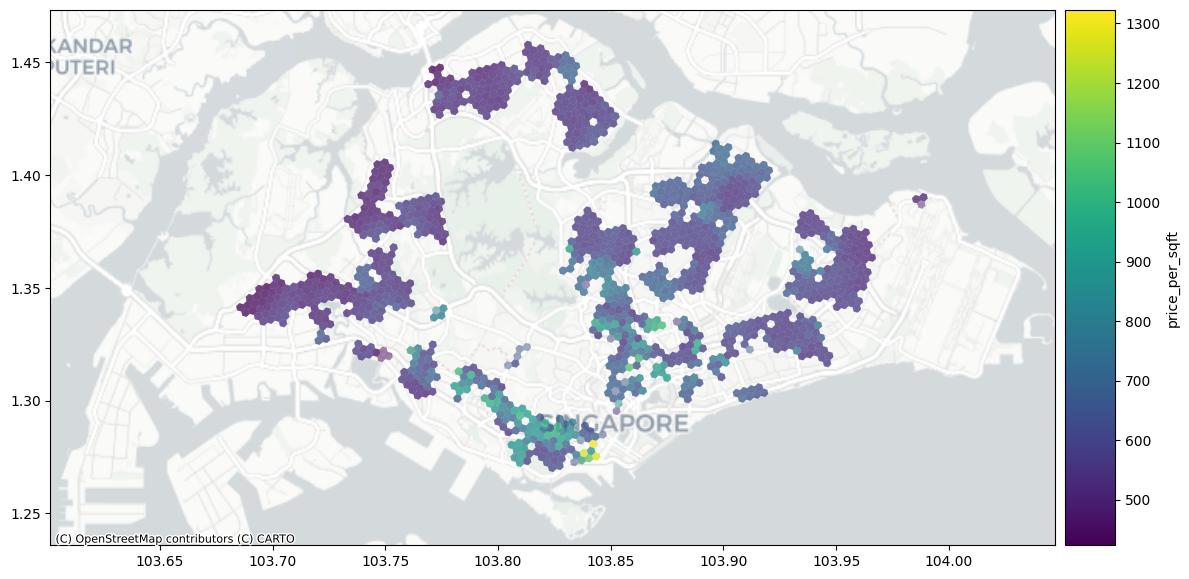

In [5]:
plot_df(
    median_prices_df_want, 
    plot_kwds = {
        "figsize": [12, 12],
        "xlim": [103.60152080468028, 104.0470051248534],
        "ylim": [1.2359029533199608, 1.4733321131970046],
        "alpha": 0.5,
        "categorical": False,
        "column": "price_per_sqft",
        "legend": True,
        "legend_kwds": {"label": "price_per_sqft"},
        "cmap": 'viridis',
        "edgecolor": None,
        "divider_kwds": {"position": "right", "size": "5%", "pad": 0.1},
    },
)